In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import numpy as np
import torch
import tqdm
import time
import cv2
import os

/opt/homebrew/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: h

# Model

In [2]:
class FireModule(nn.Module):
    def __init__(self, in_c: int, squeeze_c: int, out_c: int, stride: int = 1):
        super().__init__()
        # for all layers below, stride is default = 1

        # first point-wise convolution: 1x1
        self.squeeze = nn.Conv2d(in_channels=in_c, out_channels=squeeze_c, kernel_size=1, stride=stride)
        # first independent conv: 3x3
        self.expand1x1 = nn.Conv2d(in_channels=squeeze_c, out_channels=out_c // 2, kernel_size=3, padding=1)
        # second independent (pointwise) conv: 1x1
        self.expand3x3 = nn.Conv2d(in_channels=squeeze_c, out_channels=out_c // 2, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.squeeze(x))
        x = torch.cat([
            F.relu(self.expand1x1(x)),
            F.relu(self.expand3x3(x)),
        ], dim=1)

        return x

In [3]:
class DownSample(nn.Module):

    def __init__(self, in_c: int, squeeze_c: int, out_c: int):
        super().__init__()
        self.fire_mods = nn.Sequential(
            FireModule(in_c=in_c, squeeze_c=squeeze_c, out_c=out_c // 2, stride=2),
            FireModule(in_c=out_c // 2, squeeze_c=squeeze_c * 2, out_c=out_c, stride=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fire_mods(x)

        return x

In [4]:
class TransposedFireModule(nn.Module):
    def __init__(self, in_c: int, squeeze_c: int, out_c: int, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.t_squeeze_1x1 = nn.ConvTranspose2d(in_channels=in_c, out_channels=squeeze_c, kernel_size=1, stride=2, padding=0, output_padding=1)  # not sure of this
        # self.t_squeeze_1x1 = nn.ConvTranspose2d(in_channels=in_c, out_channels=squeeze_c, kernel_size=1, stride=4)  # not sure of this
        self.t_expand_1x1 = nn.ConvTranspose2d(in_channels=squeeze_c, out_channels=out_c // 2, kernel_size=2, stride=2, padding=0, output_padding=0) # not sure of this
        self.t_expand_2x2 = nn.ConvTranspose2d(in_channels=squeeze_c, out_channels=out_c // 2, kernel_size=2, stride=2, padding=0)  # not sure of this

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # squeeze
        x = F.relu(self.t_squeeze_1x1(x))
        # inception stage
        x = torch.cat([
            F.relu(self.t_expand_1x1(x)),
            F.relu(self.t_expand_2x2(x)),
        ], dim=1)

        return x


In [5]:
class UpSample(nn.Module):
    def __init__(self, in_c: int, t_fire_mod_out_c: int, out_c: int):
        super().__init__()
        self.t_fire_mod = TransposedFireModule(in_c=in_c, squeeze_c=in_c // 2, out_c=t_fire_mod_out_c)
        self.fire_mods = nn.Sequential(
            FireModule(in_c=t_fire_mod_out_c * 2,  # twice since transpose fire mod output is concatenated
                       squeeze_c=t_fire_mod_out_c, # squeeze with half the input size
                       out_c=out_c * 2,
                       stride=1),
            FireModule(in_c=out_c * 2, squeeze_c=out_c, out_c=out_c, stride=1),
        )

    def forward(self, x: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        x = self.t_fire_mod(x)
        x = torch.cat([x, x1,], dim=1)
        x = self.fire_mods(x)

        return x

In [6]:
class SqueezeUnet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        # first two 3x3 conv layers (3, 3, 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # contracting step
        self.ds1 = DownSample(in_c=64, squeeze_c=32, out_c=256)
        self.ds2 = DownSample(in_c=256, squeeze_c=48, out_c=1_024)
        self.ds3 = DownSample(in_c=1_024, squeeze_c=64, out_c=4_096)
        self.ds4 = DownSample(in_c=4_096, squeeze_c=80, out_c=16_384)

        # expanding step
        self.us1 = UpSample(in_c=16_384, t_fire_mod_out_c=4_096, out_c=2_048)
        self.us2 = UpSample(in_c=2_048, t_fire_mod_out_c=1_024, out_c=512)
        self.us3 = UpSample(in_c=512, t_fire_mod_out_c=256, out_c=128)

        self.t_conv = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=4, output_padding=2)  # not sure about this
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.outc = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # pre steps
        x = F.relu(self.conv1(x))
        x_conv1 = F.relu(self.conv2(x)) # skip connection to last concat after upsample

        # 4 downsampling steps
        x_ds1 = self.ds1(x=x_conv1)  # skip connection to UpSample(US) #3
        x_ds2 = self.ds2(x=x_ds1)  # skip connection to US #2
        x_ds3 = self.ds3(x=x_ds2)  # skip connection to US #1
        x_ds4 = self.ds4(x=x_ds3)

        # 3 upsampling steps
        x = self.us1(x_ds4, x_ds3)
        x = self.us2(x, x_ds2)
        x = self.us3(x, x_ds1)

        # # post steps
        x = F.relu(self.t_conv(x))
        x = torch.cat([x, x_conv1], dim=1)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        logits = F.relu(self.outc(x))

        return logits


In [7]:
t = torch.rand(1, 3, 256, 256)
sq_unet = SqueezeUnet(num_classes=2)
sq_unet(t).shape

torch.Size([1, 2, 256, 256])

# Dataset

In [8]:
BASE_DIR = "../../data/broad_dataset/"

In [9]:
class BroadDataset(Dataset):
    """
    https://bbbc.broadinstitute.org/BBBC038
    """
    def __init__(self, train_images_dir, transform = None):
        super().__init__()
        self.train_images_dir = train_images_dir
        self.transform = transform
        self.image_dirs = os.listdir(train_images_dir)
        self.fn_idx_map = {}
        for idx, fn in enumerate(self.image_dirs):
            self.fn_idx_map[idx] = fn

    def __len__(self) -> int:
        return len(self.image_dirs)

    def combine_masks(self, masks_dir: str, target_shape: tuple[int]) -> np.ndarray:
        combined_mask = np.zeros(target_shape, dtype=np.uint8)
        for mask_file in os.listdir(masks_dir):
            mask = cv2.imread(os.path.join(masks_dir, mask_file))

            combined_mask = np.maximum(combined_mask, mask)

        return combined_mask

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:
        size = self.__len__()
        if index < 0 or index >= size:
            raise ValueError(f"Invalid Index: index should be >= 0 and less than size of dataset: {size}")
        fn = self.fn_idx_map[index]
        index_dir = os.path.join(self.train_images_dir, fn)

        images_dir = os.path.join(index_dir, "images")
        masks_dir = os.path.join(index_dir, "masks")

        image_filename = os.listdir(images_dir)[0]

        image = cv2.imread(os.path.join(images_dir, image_filename))
        mask = self.combine_masks(masks_dir, image.shape)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [10]:
train_images = os.path.join(BASE_DIR, "stage1_train")
common_size = (256, 256)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(common_size, antialias=True),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),
    normalize,
])

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [11]:
train_dataset = BroadDataset(train_images, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [12]:
train_image, train_mask = next(iter(train_loader))
print(f"Feature batch shape: {train_image.shape}")
print(f"Masks batch shape: {train_mask.shape}")

img = train_image[0]  # pick first image in batch
if img.shape[0] == 3:
    img = img.permute(1, 2, 0)
plt.imshow(img)
plt.show()

RuntimeError: stack expects each tensor to be equal size, but got [3, 360, 360] at entry 0 and [3, 256, 256] at entry 1

In [ ]:
train_image[0].shape

torch.Size([3, 256, 256])

In [ ]:
m = SqueezeUnet(num_classes=2)
m(transform(train_image[0])).shape

RuntimeError: Given groups=1, weight of size [64, 128, 1, 1], expected input[1, 64, 512, 256] to have 128 channels, but got 64 channels instead

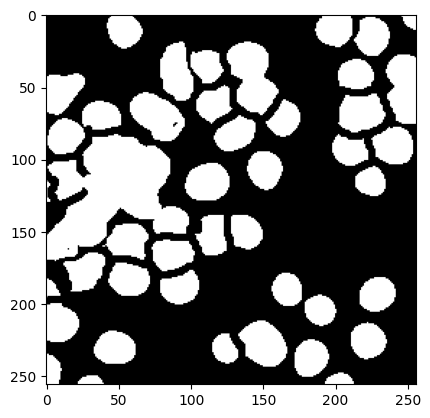

In [ ]:
mask = train_mask[0]  # pick first image in batch
if mask.shape[0] == 3:
    mask = mask.permute(1, 2, 0)
plt.axis('off')
plt.imshow(mask)
plt.show()

# Training loop

In [ ]:
def training_loop(model:nn.Module, epochs=20, lr=0.001, optimizer=Adam, loss_func=nn.BCEWithLogitsLoss):

    start_time = time.time()

    for epoch in tqdm.tqdm(range(epochs)):
        print(f"epoch: {epoch}")

        model.train()

        train_loss = 0

        for i, (x, y) in tqdm.tqdm(enumerate(train_loader)):
            pred = model(x)
            loss = loss_func(pred, y)

            model.zero_grad()
            loss.backward()
            model.step()

            train_loss += loss.item()


        avg_train_loss = train_loss / len(train_loader)
        print(f"[INFO] EPOCH: {epoch}/{epochs}")
        print(f"Train loss: {avg_train_loss:.6f}")

    # display the total time needed to perform the training
    end_time = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))


In [ ]:
model = SqueezeUnet(num_classes=2)
training_loop(model, epochs=20, lr=0.001, optimizer=Adam, loss_func=nn.BCEWithLogitsLoss)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0


0it [00:02, ?it/s]
  0%|          | 0/20 [00:02<?, ?it/s]


RuntimeError: Input type (unsigned char) and bias type (float) should be the same